Overview

The 6th place solution used strong image models like CNNs and Transformers with different backbones, image sizes, and augmentations. They applied multi-task learning by predicting extra targets like Dog/Cat labels to add diversity. Models were trained with techniques like freezing initial layers part of the backbone, . Finally, predictions from multiple diverse models were combined using hill climbing ensembles, where new models were added only if they improved cross-validation scores.

Reason for Good Performance

The solution performed well because it focused on  Multi-task learning and  freezing parts of pretrained backbones preserved learned features while training the head on this competition’s data. 

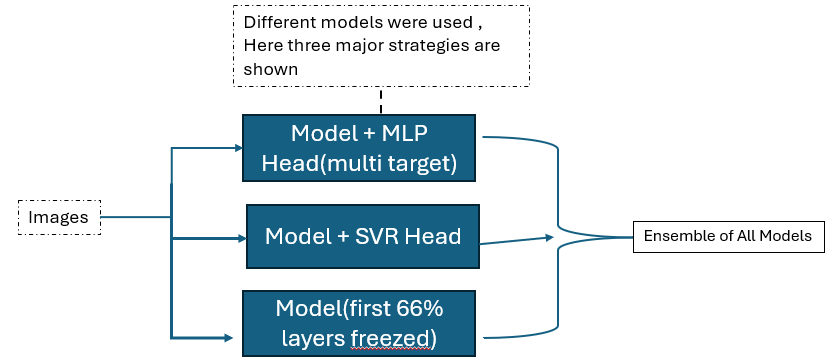

In [80]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import timm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [81]:
# ============================================================================
# Load Data
# ============================================================================
print('Loading training data...')
BASE_PATH = "inputs/"
train_df = pd.read_csv(f'{BASE_PATH}train.csv')
print(train_df.shape)
print('\nLoading pet metadata (is_cat)...')
catDog_df = pd.read_csv(f'{BASE_PATH}cats.csv')  # Contains Id and is_cat columns
print(f'CatDog data shape: {catDog_df.shape}')

print('\nMerging datasets...')
merge_train_df = train_df.merge(catDog_df, on='Id', how='left')

print(f'Merged train shape: {merge_train_df.shape}')



Loading training data...
(9912, 14)

Loading pet metadata (is_cat)...
CatDog data shape: (9912, 2)

Merging datasets...
Merged train shape: (9912, 15)


In [82]:
merge_train_df.head()
train_df = merge_train_df

In [83]:
# ============================================================================
# Configuration
# ============================================================================
class CFG:
    seed = 42
    n_folds = 5
    epochs = 5
    batch_size = 16
    num_workers = 4
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    lr = 1e-4
    weight_decay = 1e-6
    patience = 2
    min_delta = 0.01
    
    models_config = [
        {
            'name': 'tf_efficientnetv2_s',
            'img_size': 224,
            'strategy': 'svr_head',
            'description': 'EfficientNet with SVR head'
        },
        {
            'name': 'inception_v3',
            'img_size': 299,
            'strategy': 'freeze_66',
            'description': 'Inception 299 with 66% frozen backbone'
        },
        {
            'name': 'swin_base_patch4_window7_224',
            'img_size': 224,
            'strategy': 'multitask',
            'description': 'Swin 224 with Dog/Cat auxiliary'
        },
    ]
    
    train_dir = BASE_PATH+'train'


In [ ]:
# ============================================================================
# Utility Functions
# ============================================================================
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def petfinder_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def freeze_batchnorm_layers(model):
    """Freeze all BatchNorm layers """
    for module in model.modules():
        if isinstance(module, (nn.BatchNorm2d, nn.BatchNorm1d)):
            module.eval()
            for param in module.parameters():
                param.requires_grad = False

def freeze_backbone_percentage(model, freeze_ratio=0.66):
    """Freeze first X% of backbone layers"""
    all_params = list(model.backbone.parameters())
    num_freeze = int(len(all_params) * freeze_ratio)
    
    for i, param in enumerate(all_params):
        if i < num_freeze:
            param.requires_grad = False
        else:
            param.requires_grad = True
    
    trainable = sum(p.requires_grad for p in model.backbone.parameters())
    total = len(all_params)
    print(f"Frozen {num_freeze}/{total} backbone parameters ({freeze_ratio*100:.0f}%)")
    print(f"Trainable backbone parameters: {trainable}/{total}")

# ============================================================================
# Data Augmentation
# ============================================================================
def get_train_transforms(img_size=224):
    return A.Compose([
        A.RandomResizedCrop(size=(img_size, img_size), scale=(0.8, 1.0)),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Transpose(p=0.3),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])

def get_valid_transforms(img_size=224):
    return A.Compose([
        A.Resize(height=img_size, width=img_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])


In [85]:
# ============================================================================
# Dataset
# ============================================================================
class PawpularityDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, return_aux=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.return_aux = return_aux
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['Id'] + '.jpg')
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(image=img)['image']
        
        target = torch.tensor(row['Pawpularity'], dtype=torch.float32)
        
        if self.return_aux:
            aux_target = torch.tensor(row['is_cat'], dtype=torch.float32)
            return img, target, aux_target
        
        return img, target


In [ ]:
# ============================================================================
# Model 1: Standard Model with Freezing Option 
# ============================================================================
class StandardModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()

        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg'   #  to get the shape in (B, C) form
        )

        self.feat_dim = self.backbone.num_features  

        self.head = nn.Sequential(
            nn.Linear(self.feat_dim, 12),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(12, 1)
        )

    def forward(self, x):
        features = self.backbone(x)  
        output = self.head(features)
        return output.squeeze(-1)


In [ ]:
# ============================================================================
# Model 2: Multi-Task Model 
# ============================================================================
class MultiTaskModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()

        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg'  
        )

        self.feat_dim = self.backbone.num_features  

        self.shared_head = nn.Sequential(
            nn.Linear(self.feat_dim, 12),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.pawpularity_head = nn.Linear(12, 1)
        self.aux_head = nn.Linear(12, 1)

    def forward(self, x):
        features = self.backbone(x)  # 

        shared = self.shared_head(features)
        pawpularity = self.pawpularity_head(shared).squeeze(-1)
        aux = self.aux_head(shared).squeeze(-1)

        return pawpularity, aux


In [ ]:
class CNNWithSVRHead(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()

        # Load backbone 
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg'
        )

        # Freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Feature dimension directly from model attribute 
        self.feat_dim = self.backbone.num_features

        self.svr_model = None  

    def forward(self, x):
        # Only extract features
        with torch.no_grad():
            feats = self.backbone(x)
        return feats

    def extract_features(self, dataloader, device):
        self.eval()
        feats, targets = [], []

        with torch.no_grad():
            for images, y in dataloader:
                images = images.to(device)
                f = self.backbone(images)
                feats.append(f.cpu().numpy())
                targets.append(y.numpy())

        return np.concatenate(feats), np.concatenate(targets)


In [ ]:
# ============================================================================
# Training Functions
# ============================================================================
def train_epoch_standard(model, loader, criterion, optimizer, device):
    model.train()
    freeze_batchnorm_layers(model)
    running_loss = 0.0
    
    pbar = tqdm(loader, desc='Training')
    for images, targets in pbar:
        images = images.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})
    
    return running_loss / len(loader)

def valid_epoch_standard(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds = []
    targets_list = []
    
    with torch.no_grad():
        for images, targets in tqdm(loader, desc='Validation'):
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            preds.extend(outputs.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())
    
    rmse = petfinder_rmse(targets_list, preds)
    return running_loss / len(loader), rmse, np.array(preds)

def train_epoch_multitask(model, loader, criterion_main, criterion_aux, optimizer, device):
    model.train()
    freeze_batchnorm_layers(model)
    running_loss = 0.0
    
    pbar = tqdm(loader, desc='Training Multi-task')
    for images, targets, aux_targets in pbar:
        images = images.to(device)
        targets = targets.to(device)
        aux_targets = aux_targets.to(device)
        
        optimizer.zero_grad()
        pawpularity_pred, aux_pred = model(images)
        
        loss_main = criterion_main(pawpularity_pred, targets)
        loss_aux = criterion_aux(aux_pred, aux_targets)
        loss = loss_main + 0.3 * loss_aux # weight for aux output influence
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})
    
    return running_loss / len(loader)

def valid_epoch_multitask(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds = []
    targets_list = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Validation Multi-task'):
            if len(batch) == 3:
                images, targets, _ = batch
            else:
                images, targets = batch
            
            images = images.to(device)
            targets = targets.to(device)
            
            pawpularity_pred, _ = model(images)
            loss = criterion(pawpularity_pred, targets)
            
            running_loss += loss.item()
            preds.extend(pawpularity_pred.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())
    
    rmse = petfinder_rmse(targets_list, preds)
    return running_loss / len(loader), rmse, np.array(preds)

In [ ]:
# ============================================================================
# Training Pipeline - SVR Head 
# ============================================================================
def train_fold_svr(config, train_df, fold, cfg):
    model_name = config['name']
    img_size = config['img_size']
    
    print(f'\n{"="*60}')
    print(f'Training {model_name} - Fold {fold+1}/{cfg.n_folds}')
    print(f'Strategy: Frozen CNN + SVR Head')
    print(f'{"="*60}')
    
    train_idx = train_df[train_df['fold'] != fold].index
    valid_idx = train_df[train_df['fold'] == fold].index
    
    train_fold_df = train_df.loc[train_idx]
    valid_fold_df = train_df.loc[valid_idx]
    
    train_dataset = PawpularityDataset(
        train_fold_df, cfg.train_dir, 
        transform=get_valid_transforms(img_size)
    )
    valid_dataset = PawpularityDataset(
        valid_fold_df, cfg.train_dir, 
        transform=get_valid_transforms(img_size)
    )
    
    train_loader = DataLoader(
        train_dataset, batch_size=cfg.batch_size, 
        shuffle=False, num_workers=cfg.num_workers, pin_memory=True
    )
    valid_loader = DataLoader(
        valid_dataset, batch_size=cfg.batch_size, 
        shuffle=False, num_workers=cfg.num_workers, pin_memory=True
    )
    
    model = CNNWithSVRHead(model_name, pretrained=True)
    model = model.to(cfg.device)
    
    print("Extracting training features...")
    X_train, y_train = model.extract_features(train_loader, cfg.device)
    
    print("Extracting validation features...")
    X_valid, y_valid = model.extract_features(valid_loader, cfg.device)
    
    print("Training SVR...")
    svr = SVR(kernel='rbf', C=10.0, epsilon=0.1, gamma='scale')
    svr.fit(X_train, y_train)
    
    valid_preds = svr.predict(X_valid)
    valid_rmse = petfinder_rmse(y_valid, valid_preds)
    
    print(f'Valid RMSE: {valid_rmse:.4f}')
    
    return valid_rmse, valid_preds, valid_idx

In [ ]:
# ============================================================================
# Training Pipeline - 66% Frozen Backbone 
# ============================================================================
def train_fold_freeze66(config, train_df, fold, cfg):
    model_name = config['name']
    img_size = config['img_size']
    
    print(f'\n{"="*60}')
    print(f'Training {model_name} - Fold {fold+1}/{cfg.n_folds}')
    print(f'Strategy: 66% Frozen Backbone + Train Head')
    print(f'{"="*60}')
    
    train_idx = train_df[train_df['fold'] != fold].index
    valid_idx = train_df[train_df['fold'] == fold].index
    
    train_fold_df = train_df.loc[train_idx]
    valid_fold_df = train_df.loc[valid_idx]
    
    train_dataset = PawpularityDataset(
        train_fold_df, cfg.train_dir, 
        transform=get_train_transforms(img_size)
    )
    valid_dataset = PawpularityDataset(
        valid_fold_df, cfg.train_dir, 
        transform=get_valid_transforms(img_size)
    )
    
    train_loader = DataLoader(
        train_dataset, batch_size=cfg.batch_size, 
        shuffle=True, num_workers=cfg.num_workers, pin_memory=True
    )
    valid_loader = DataLoader(
        valid_dataset, batch_size=cfg.batch_size, 
        shuffle=False, num_workers=cfg.num_workers, pin_memory=True
    )
    
    model = StandardModel(model_name, pretrained=True)
    freeze_backbone_percentage(model, freeze_ratio=0.66)
    model = model.to(cfg.device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=cfg.lr, 
        weight_decay=cfg.weight_decay
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=cfg.epochs
    )
    
    best_rmse = float('inf')
    best_preds = None
    patience_counter = 0
    
    for epoch in range(cfg.epochs):
        print(f'\nEpoch {epoch+1}/{cfg.epochs}')
        
        train_loss = train_epoch_standard(
            model, train_loader, criterion, optimizer, cfg.device
        )
        valid_loss, valid_rmse, valid_preds = valid_epoch_standard(
            model, valid_loader, criterion, cfg.device
        )
        scheduler.step()
        
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid RMSE: {valid_rmse:.4f}')
        
        if valid_rmse < best_rmse - cfg.min_delta:
            best_rmse = valid_rmse
            best_preds = valid_preds
            torch.save(model.state_dict(), f'{model_name}_freeze66_fold{fold}_best.pth')
            print(f'Best RMSE improved: {best_rmse:.4f}')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= cfg.patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    return best_rmse, best_preds, valid_idx


In [ ]:

# ============================================================================
# Training Pipeline - Multi-Task Strategy
# ============================================================================
def train_fold_multitask(config, train_df, fold, cfg):
    model_name = config['name']
    img_size = config['img_size']
    
    print(f'\n{"="*60}')
    print(f'Training {model_name} - Fold {fold+1}/{cfg.n_folds}')
    print(f'Strategy: Multi-Task Learning (Dog/Cat Auxiliary)')
    print(f'{"="*60}')
    
    train_idx = train_df[train_df['fold'] != fold].index
    valid_idx = train_df[train_df['fold'] == fold].index
    
    train_fold_df = train_df.loc[train_idx]
    valid_fold_df = train_df.loc[valid_idx]
    
    train_dataset = PawpularityDataset(
        train_fold_df, cfg.train_dir, 
        transform=get_train_transforms(img_size),
        return_aux=True
    )
    valid_dataset = PawpularityDataset(
        valid_fold_df, cfg.train_dir, 
        transform=get_valid_transforms(img_size),
        return_aux=True
    )
    
    train_loader = DataLoader(
        train_dataset, batch_size=cfg.batch_size, 
        shuffle=True, num_workers=cfg.num_workers, pin_memory=True
    )
    valid_loader = DataLoader(
        valid_dataset, batch_size=cfg.batch_size, 
        shuffle=False, num_workers=cfg.num_workers, pin_memory=True
    )
    
    model = MultiTaskModel(model_name, pretrained=True)
    model = model.to(cfg.device)
    
    criterion_main = nn.MSELoss()
    criterion_aux = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=cfg.epochs
    )
    
    best_rmse = float('inf')
    best_preds = None
    patience_counter = 0
    
    for epoch in range(cfg.epochs):
        print(f'\nEpoch {epoch+1}/{cfg.epochs}')
        
        train_loss = train_epoch_multitask(
            model, train_loader, criterion_main, criterion_aux, optimizer, cfg.device
        )
        valid_loss, valid_rmse, valid_preds = valid_epoch_multitask(
            model, valid_loader, criterion_main, cfg.device
        )
        scheduler.step()
        
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid RMSE: {valid_rmse:.4f}')
        
        if valid_rmse < best_rmse - cfg.min_delta:
            best_rmse = valid_rmse
            best_preds = valid_preds
            torch.save(model.state_dict(), f'{model_name}_multitask_fold{fold}_best.pth')
            print(f'Best RMSE improved: {best_rmse:.4f}')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= cfg.patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    return best_rmse, best_preds, valid_idx


In [93]:

# ============================================================================
# Create Stratified Folds
# ============================================================================
print('\n' + '='*60)
print('Creating stratified folds...')
print('='*60)

set_seed(CFG.seed)

train_df['bins'] = pd.cut(train_df['Pawpularity'], bins=10, labels=False)
skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
train_df['fold'] = -1

for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df['bins'])):
    train_df.loc[valid_idx, 'fold'] = fold

print(f'Fold distribution:')
print(train_df['fold'].value_counts().sort_index())



Creating stratified folds...
Fold distribution:
fold
0    1983
1    1983
2    1982
3    1982
4    1982
Name: count, dtype: int64


In [94]:
# ============================================================================
# Train All Models
# ============================================================================
print('\n' + '='*60)
print('TRAINING THREE DIVERSE MODELS')
print('='*60)

all_oof_preds = {}

for config in CFG.models_config:
    print(f'\n{"#"*60}')
    print(f'Model: {config["description"]}')
    print(f'{"#"*60}')
    
    oof_preds = np.zeros(len(train_df))
    cv_scores = []
    
    for fold in range(CFG.n_folds):
        strategy = config['strategy']
        
        if strategy == 'svr_head':
            fold_rmse, fold_preds, valid_idx = train_fold_svr(
                config, train_df, fold, CFG
            )
        elif strategy == 'freeze_66':
            fold_rmse, fold_preds, valid_idx = train_fold_freeze66(
                config, train_df, fold, CFG
            )
        elif strategy == 'multitask':
            fold_rmse, fold_preds, valid_idx = train_fold_multitask(
                config, train_df, fold, CFG
            )
        
        oof_preds[valid_idx] = fold_preds
        cv_scores.append(fold_rmse)
    
    overall_cv = petfinder_rmse(train_df['Pawpularity'].values, oof_preds)
    
    print(f'\n{config["description"]} Results:')
    print(f'Fold RMSEs: {[f"{s:.4f}" for s in cv_scores]}')
    print(f'Mean Fold RMSE: {np.mean(cv_scores):.4f} +/- {np.std(cv_scores):.4f}')
    print(f'Overall OOF RMSE: {overall_cv:.4f}')
    
    all_oof_preds[config['name']] = oof_preds
    
    np.save(f'oof_{config["name"]}.npy', oof_preds)
    print(f'Saved OOF to oof_{config["name"]}.npy')



TRAINING THREE DIVERSE MODELS

############################################################
Model: EfficientNet with SVR head
############################################################

Training tf_efficientnetv2_s - Fold 1/5
Strategy: Frozen CNN + SVR Head
Extracting training features...
Extracting validation features...
Training SVR...
Valid RMSE: 20.7597

Training tf_efficientnetv2_s - Fold 2/5
Strategy: Frozen CNN + SVR Head
Extracting training features...
Extracting validation features...
Training SVR...
Valid RMSE: 20.7653

Training tf_efficientnetv2_s - Fold 3/5
Strategy: Frozen CNN + SVR Head
Extracting training features...
Extracting validation features...
Training SVR...
Valid RMSE: 20.9117

Training tf_efficientnetv2_s - Fold 4/5
Strategy: Frozen CNN + SVR Head
Extracting training features...
Extracting validation features...
Training SVR...
Valid RMSE: 20.8510

Training tf_efficientnetv2_s - Fold 5/5
Strategy: Frozen CNN + SVR Head
Extracting training features...
Extract

Validation: 100%|██████████| 124/124 [00:05<00:00, 23.67it/s]


Train Loss: 611.5267
Valid Loss: 497.8578, Valid RMSE: 22.3134
Best RMSE improved: 22.3134

Epoch 2/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 23.77it/s]


Train Loss: 566.4936
Valid Loss: 422.9027, Valid RMSE: 20.5648
Best RMSE improved: 20.5648

Epoch 3/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 23.76it/s]


Train Loss: 549.3987
Valid Loss: 348.0200, Valid RMSE: 18.6556
Best RMSE improved: 18.6556

Epoch 4/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 23.69it/s]


Train Loss: 530.3504
Valid Loss: 359.7675, Valid RMSE: 18.9668

Epoch 5/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 23.75it/s]


Train Loss: 507.4991
Valid Loss: 367.2888, Valid RMSE: 19.1643
Early stopping at epoch 5

Training inception_v3 - Fold 2/5
Strategy: 66% Frozen Backbone + Train Head
Frozen 186/282 backbone parameters (66%)
Trainable backbone parameters: 96/282

Epoch 1/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 23.63it/s]


Train Loss: 523.9399
Valid Loss: 386.1227, Valid RMSE: 19.6460
Best RMSE improved: 19.6460

Epoch 2/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 23.66it/s]


Train Loss: 460.2430
Valid Loss: 392.8917, Valid RMSE: 19.8171

Epoch 3/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 23.68it/s]


Train Loss: 454.4995
Valid Loss: 345.9036, Valid RMSE: 18.5947
Best RMSE improved: 18.5947

Epoch 4/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 23.64it/s]


Train Loss: 417.0096
Valid Loss: 365.3591, Valid RMSE: 19.1106

Epoch 5/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 23.75it/s]


Train Loss: 391.1118
Valid Loss: 340.7332, Valid RMSE: 18.4560
Best RMSE improved: 18.4560

Training inception_v3 - Fold 3/5
Strategy: 66% Frozen Backbone + Train Head
Frozen 186/282 backbone parameters (66%)
Trainable backbone parameters: 96/282

Epoch 1/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 23.77it/s]


Train Loss: 534.7722
Valid Loss: 413.9455, Valid RMSE: 20.3444
Best RMSE improved: 20.3444

Epoch 2/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 23.80it/s]


Train Loss: 455.6639
Valid Loss: 348.4519, Valid RMSE: 18.6641
Best RMSE improved: 18.6641

Epoch 3/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 22.73it/s]


Train Loss: 443.8234
Valid Loss: 350.4304, Valid RMSE: 18.7173

Epoch 4/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 22.89it/s]


Train Loss: 413.5768
Valid Loss: 338.2447, Valid RMSE: 18.3885
Best RMSE improved: 18.3885

Epoch 5/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 22.97it/s]


Train Loss: 398.0029
Valid Loss: 343.4137, Valid RMSE: 18.5280

Training inception_v3 - Fold 4/5
Strategy: 66% Frozen Backbone + Train Head
Frozen 186/282 backbone parameters (66%)
Trainable backbone parameters: 96/282

Epoch 1/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 22.86it/s]


Train Loss: 517.0745
Valid Loss: 425.7775, Valid RMSE: 20.6371
Best RMSE improved: 20.6371

Epoch 2/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 22.87it/s]


Train Loss: 472.4273
Valid Loss: 388.5711, Valid RMSE: 19.7151
Best RMSE improved: 19.7151

Epoch 3/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 22.90it/s]


Train Loss: 445.5759
Valid Loss: 354.3430, Valid RMSE: 18.8264
Best RMSE improved: 18.8264

Epoch 4/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 22.86it/s]


Train Loss: 419.1485
Valid Loss: 332.9258, Valid RMSE: 18.2490
Best RMSE improved: 18.2490

Epoch 5/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 22.79it/s]


Train Loss: 411.2589
Valid Loss: 338.8857, Valid RMSE: 18.4121

Training inception_v3 - Fold 5/5
Strategy: 66% Frozen Backbone + Train Head
Frozen 186/282 backbone parameters (66%)
Trainable backbone parameters: 96/282

Epoch 1/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 22.86it/s]


Train Loss: 609.8019
Valid Loss: 373.2077, Valid RMSE: 19.3201
Best RMSE improved: 19.3201

Epoch 2/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 22.74it/s]


Train Loss: 568.6130
Valid Loss: 504.4828, Valid RMSE: 22.4615

Epoch 3/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 22.67it/s]


Train Loss: 531.4478
Valid Loss: 360.9241, Valid RMSE: 19.0035
Best RMSE improved: 19.0035

Epoch 4/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 22.77it/s]


Train Loss: 517.9351
Valid Loss: 383.3013, Valid RMSE: 19.5804

Epoch 5/5


Validation: 100%|██████████| 124/124 [00:05<00:00, 22.73it/s]


Train Loss: 510.0183
Valid Loss: 349.1817, Valid RMSE: 18.6901
Best RMSE improved: 18.6901

Inception 299 with 66% frozen backbone Results:
Fold RMSEs: ['18.6556', '18.4560', '18.3885', '18.2490', '18.6901']
Mean Fold RMSE: 18.4879 +/- 0.1655
Overall OOF RMSE: 18.4886
Saved OOF to oof_inception_v3.npy

############################################################
Model: Swin 224 with Dog/Cat auxiliary
############################################################

Training swin_base_patch4_window7_224 - Fold 1/5
Strategy: Multi-Task Learning (Dog/Cat Auxiliary)

Epoch 1/5


Validation Multi-task: 100%|██████████| 124/124 [00:15<00:00,  8.21it/s]


Train Loss: 666.9262
Valid Loss: 441.4822, Valid RMSE: 21.0120
Best RMSE improved: 21.0120

Epoch 2/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.30it/s]


Train Loss: 576.7656
Valid Loss: 441.3713, Valid RMSE: 21.0094

Epoch 3/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.30it/s]


Train Loss: 569.3437
Valid Loss: 435.7858, Valid RMSE: 20.8760
Best RMSE improved: 20.8760

Epoch 4/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.31it/s]


Train Loss: 565.6084
Valid Loss: 444.8667, Valid RMSE: 21.0924

Epoch 5/5


Validation Multi-task: 100%|██████████| 124/124 [00:15<00:00,  8.08it/s]


Train Loss: 571.0285
Valid Loss: 436.3803, Valid RMSE: 20.8902
Early stopping at epoch 5

Training swin_base_patch4_window7_224 - Fold 2/5
Strategy: Multi-Task Learning (Dog/Cat Auxiliary)

Epoch 1/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.28it/s]


Train Loss: 723.3400
Valid Loss: 441.5115, Valid RMSE: 21.0098
Best RMSE improved: 21.0098

Epoch 2/5


Validation Multi-task: 100%|██████████| 124/124 [00:15<00:00,  8.10it/s]


Train Loss: 577.4205
Valid Loss: 437.3921, Valid RMSE: 20.9116
Best RMSE improved: 20.9116

Epoch 3/5


Validation Multi-task: 100%|██████████| 124/124 [00:15<00:00,  7.81it/s]


Train Loss: 566.7174
Valid Loss: 430.3003, Valid RMSE: 20.7415
Best RMSE improved: 20.7415

Epoch 4/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.30it/s]


Train Loss: 562.9805
Valid Loss: 441.1814, Valid RMSE: 21.0019

Epoch 5/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.30it/s]


Train Loss: 574.4339
Valid Loss: 438.4729, Valid RMSE: 20.9373
Early stopping at epoch 5

Training swin_base_patch4_window7_224 - Fold 3/5
Strategy: Multi-Task Learning (Dog/Cat Auxiliary)

Epoch 1/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.33it/s]


Train Loss: 645.0128
Valid Loss: 455.7593, Valid RMSE: 21.3503
Best RMSE improved: 21.3503

Epoch 2/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.34it/s]


Train Loss: 556.7852
Valid Loss: 443.9922, Valid RMSE: 21.0728
Best RMSE improved: 21.0728

Epoch 3/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.34it/s]


Train Loss: 540.5244
Valid Loss: 433.9370, Valid RMSE: 20.8328
Best RMSE improved: 20.8328

Epoch 4/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.34it/s]


Train Loss: 536.1454
Valid Loss: 436.0387, Valid RMSE: 20.8832

Epoch 5/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.33it/s]


Train Loss: 543.9137
Valid Loss: 434.4924, Valid RMSE: 20.8461
Early stopping at epoch 5

Training swin_base_patch4_window7_224 - Fold 4/5
Strategy: Multi-Task Learning (Dog/Cat Auxiliary)

Epoch 1/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.33it/s]


Train Loss: 594.4956
Valid Loss: 432.2698, Valid RMSE: 20.7935
Best RMSE improved: 20.7935

Epoch 2/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.33it/s]


Train Loss: 532.2045
Valid Loss: 430.2142, Valid RMSE: 20.7441
Best RMSE improved: 20.7441

Epoch 3/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.33it/s]


Train Loss: 527.4396
Valid Loss: 425.6941, Valid RMSE: 20.6349
Best RMSE improved: 20.6349

Epoch 4/5


Validation Multi-task: 100%|██████████| 124/124 [00:15<00:00,  7.85it/s]


Train Loss: 521.4093
Valid Loss: 427.9297, Valid RMSE: 20.6889

Epoch 5/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.33it/s]


Train Loss: 524.7784
Valid Loss: 433.2062, Valid RMSE: 20.8160
Early stopping at epoch 5

Training swin_base_patch4_window7_224 - Fold 5/5
Strategy: Multi-Task Learning (Dog/Cat Auxiliary)

Epoch 1/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.31it/s]


Train Loss: 632.1212
Valid Loss: 435.4744, Valid RMSE: 20.8690
Best RMSE improved: 20.8690

Epoch 2/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.32it/s]


Train Loss: 526.8969
Valid Loss: 443.3298, Valid RMSE: 21.0562

Epoch 3/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.31it/s]


Train Loss: 530.0638
Valid Loss: 424.0785, Valid RMSE: 20.5946
Best RMSE improved: 20.5946

Epoch 4/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.32it/s]


Train Loss: 529.5049
Valid Loss: 427.4357, Valid RMSE: 20.6758

Epoch 5/5


Validation Multi-task: 100%|██████████| 124/124 [00:14<00:00,  8.32it/s]

Train Loss: 528.0123
Valid Loss: 429.0231, Valid RMSE: 20.7140
Early stopping at epoch 5

Swin 224 with Dog/Cat auxiliary Results:
Fold RMSEs: ['20.8760', '20.7415', '20.8328', '20.6349', '20.5946']
Mean Fold RMSE: 20.7359 +/- 0.1088
Overall OOF RMSE: 20.7363
Saved OOF to oof_swin_base_patch4_window7_224.npy


In [95]:
# ============================================================================
# Ensemble Results
# ============================================================================
print(f'\n{"="*60}')
print('ENSEMBLE RESULTS')
print(f'{"="*60}')

ensemble_preds = np.mean(list(all_oof_preds.values()), axis=0)
ensemble_rmse = petfinder_rmse(train_df['Pawpularity'].values, ensemble_preds)

print(f'\nEnsemble OOF RMSE: {ensemble_rmse:.4f}')
print('\nIndividual Model RMSEs:')
for i, (model_name, preds) in enumerate(all_oof_preds.items()):
    rmse = petfinder_rmse(train_df['Pawpularity'].values, preds)
    strategy = CFG.models_config[i]['strategy']
    print(f'  {model_name} ({strategy}): {rmse:.4f}')

improvement = min([petfinder_rmse(train_df['Pawpularity'].values, preds) 
                   for preds in all_oof_preds.values()]) - ensemble_rmse
print(f'\nEnsemble improvement over best single model: {improvement:.4f}')

# ============================================================================
# Save Final Results
# ============================================================================
oof_df = pd.DataFrame({
    'Id': train_df['Id'],
    'Pawpularity': train_df['Pawpularity'],
    'ensemble_pred': ensemble_preds
})

for model_name, preds in all_oof_preds.items():
    oof_df[f'{model_name}_pred'] = preds

oof_df.to_csv('top6_oof_predictions_final.csv', index=False)
print('\nOOF predictions saved to oof_predictions_final.csv')

print(f'\n{"="*60}')
print('Training Complete')
print(f'{"="*60}')


ENSEMBLE RESULTS

Ensemble OOF RMSE: 19.4803

Individual Model RMSEs:
  tf_efficientnetv2_s (svr_head): 20.7956
  inception_v3 (freeze_66): 18.4886
  swin_base_patch4_window7_224 (multitask): 20.7363

Ensemble improvement over best single model: -0.9917

OOF predictions saved to oof_predictions_final.csv

Training Complete
